In [1]:
import numpy as np
import pandas as pd
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [28]:
#sampling interval and tmax
def tmax_and_sample_interval(sim,samples_per_orbit,n_orbits):
    o = sim.calculate_orbits(heliocentric=True)
    return o[0].P/samples_per_orbit, o[0].P*n_orbits*2*np.pi

#get fft
def get_fft(signal,tmax):
    Npts = len(signal)
    fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(Npts, tmax/Npts)
    return freq, fft, np.max(freq)

#remove high freq 
def low_pass(signal,tmax,fcut):
    freq, fft, fmax = get_fft(signal,tmax)
    fft[np.abs(freq) > fcut] = 0
    return np.fft.ifft(fft)

def write(f,sim):
    o = sim.calculate_orbits(heliocentric=True)
    f.write("%e,%e,%e,%e,%e,%e\n"%(sim.t,o[0].P,o[0].a,o[0].e,o[0].omega,o[0].M))

### Generate data

In [9]:
filename='data/ic0000000.bin'
sim = rebound.Simulation.from_file(filename)
sim.status()

---------------------------------
REBOUND version:     	3.4.0
REBOUND built on:    	May 11 2017 15:14:36
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=2.15130954841e-05 y=-2.83134950296e-05 z=-3.59702797063e-07 vx=0.000184889789743 vy=0.000118365239205 vz=-2.10835927452e-06>
<rebound.Particle object, m=3.41401601921e-05 x=-0.0658395691021 y=0.997590609731 z=-0.00120070677257 vx=-6.26836429024 vy=-0.445311904669 vz=0.0559526195024>
<rebound.Particle object, m=1.87872497534e-05 x=-1.14094577147 y=-0.203694227095 z=0.0167610663709 vx=1.22970372256 vy=-5.8554285143 vz=-0.0177819457008>
<rebound.Particle object, m=1.82689985991e-06 x=1.18775591557 y=-1.04962177571 z=0.0469652335416 vx=3.28995608402 vy=3.74688214542 vz=0.291314126296>
---------------------------------


In [10]:
samples_per_orbit = 3
n_orbital_periods = 1e4
dt, tmax = tmax_and_sample_interval(sim,samples_per_orbit,n_orbital_periods)
f = open('data/ic0000000_spo%d.txt'%samples_per_orbit,'w')

write(f,sim)
while sim.t < tmax:
    sim.integrate(sim.t + dt)
    write(f,sim)
write(f,sim)
f.close()

### Analyze Data

In [25]:
filename = 'data/ic0000000_spo3.txt'
spo = float(filename.split('_spo')[1].split('.txt')[0]) #samples per orbit (original)
names = ['time','a1','P1','e1','w1','M1']
data = pd.read_csv(filename, names=names)

In [26]:
data.head()

,time,a1,P1,e1,w1,M1
0,0.000000,0.999983,1.000000,0.005031,1.400202,-1.524274
1,0.333328,0.999940,0.999972,0.005015,1.404913,0.565491
2,0.666655,0.999971,0.999992,0.004981,1.407776,2.657144
3,0.999983,1.000353,1.000247,0.004708,1.381627,-1.506064
4,1.333311,0.999778,0.999863,0.004259,1.399055,0.570190


2
3
10
20


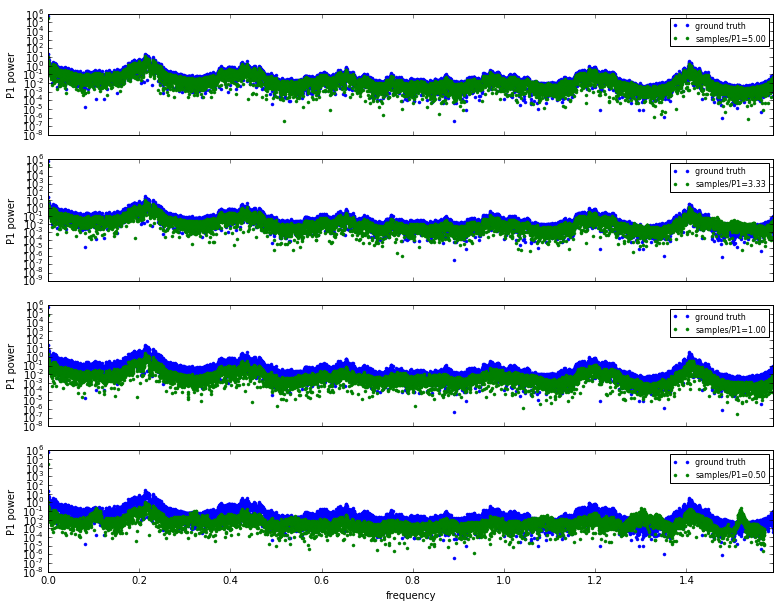

In [42]:
#FFT vs. sample rate
var = "P1"
tmax = data['time'].iloc[-1]/(2*np.pi)
npoints = [2,3,10,20]               #take every nth data point and compare to original

freqt, fftt, fmaxt = get_fft(data[var],tmax)
f, ax = plt.subplots(len(npoints), sharex=True, figsize=(13,10))
for i,n in enumerate(npoints):
    freq, fft, fmax = get_fft(data[var][0::n],tmax)
    ax[i].plot(freqt,fftt,'.', label='ground truth')
    ax[i].plot(freq,fft,'.', label='samples/P1=%.2f'%(spo/float(n)))  #sampling rate (per orbital period)
    ax[i].legend(fontsize=8);
    ax[i].set_yscale('log');
    ax[i].set_ylabel('%s power'%var);
    print n

plt.xlim([0,fmax+0.02]);
plt.xlabel('frequency');
plt.savefig("images/FFT_v_sampling_rate_%s.png"%var)

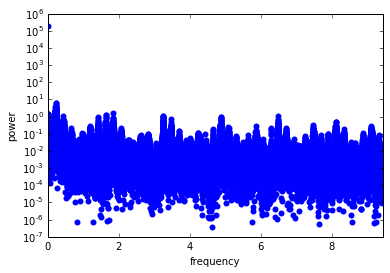

In [36]:
#fft plot
tmax = data['time'].iloc[-1]/(2*np.pi)
freq, fft, fmax = get_fft(data['P1'],tmax)
plt.plot(freq,fft, 'o', mew=0)
plt.xlim([0,fmax+0.02])
plt.yscale('log');
plt.xlabel('frequency');
plt.ylabel('power');
#plt.savefig('images/fft_P1_spo%d.png'%spo)

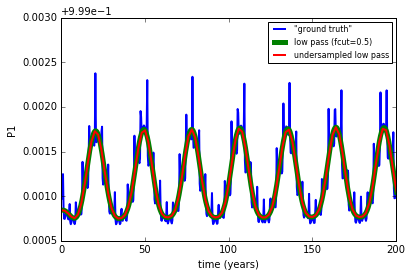

In [32]:
#timeseries plots
var = "P1"
fcut = 0.5
F_under = 6   #undersampling factor

t = (data['time'].iloc[1] - data['time'].iloc[0])*np.arange(len(data[var]))
LP = low_pass(data[var],tmax,fcut)
LP_under = LP[0::F_under]
t_under = t[0::F_under]

plt.plot(t,data[var], lw=2,label='"ground truth"')
plt.plot(t, LP, lw=5,label='low pass (fcut=%.1f)'%fcut)
plt.plot(t_under,LP_under, lw=2,label='undersampled low pass')
plt.xlabel('time (years)');
plt.ylabel(var)
plt.legend(fontsize=8)
plt.xlim([0,200]);
plt.savefig('images/lowpass_%s.png'%var)

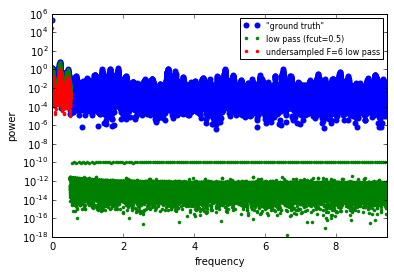

In [75]:
#re-compute FFT of lowpass and compare to original fft
freqLP, fftLP, fmax = get_fft(LP,tmax)
freqLPu, fftLPu, fmaxu = get_fft(LP_under,tmax)
plt.plot(freq,fft, 'o', mew=0, label='"ground truth"')
plt.plot(freqLP,fftLP, '.', label='low pass (fcut=%.1f)'%fcut)
plt.plot(freqLPu,fftLPu, '.', label='undersampled F=%d low pass'%F_under)
plt.xlim([0,fmax+0.02])
plt.yscale('log');
plt.xlabel('frequency');
plt.ylabel('power');
plt.legend(fontsize=8)
plt.savefig('images/fftcomp_%s.png'%var)